## 1-1. Data を読み込んでみよう

In [1]:
# Data を読み込む
import pandas as pd

df_info = pd.read_csv('accomodation_info.csv', index_col=0, parse_dates=[0])
df_info

,顧客ID,宿泊者名,プラン,金額
日時,,,,
2018-11-01 00:02:21,110034,若松 花子,B,19000
2018-11-01 00:03:10,112804,津田 美加子,D,20000
2018-11-01 00:06:19,110275,吉本 美加子,D,20000
2018-11-01 00:08:41,110169,坂本 直人,B,19000
2018-11-01 00:12:22,111504,青山 零,A,15000
...,...,...,...,...
2020-10-31 23:38:51,110049,吉本 篤司,A,3000
2020-10-31 23:42:12,110127,喜嶋 浩,A,3000
2020-10-31 23:47:24,115464,藤本 明美,D,8000


- 宿泊料金は、曜日や季節によって変動する。
    ※ コロナウイルス感染症の流行後は大幅な値下げを行なっている。
- Plan は４つあり、感染症流行前は、Restaurant での朝夕食付き Plan が人気だった。

| Plan | 内容          |
|------|-------------|
| A    | 素泊まり        |
| B    | 朝夕食付        |
| C    | 素泊まり露天風呂付客室 |
| D    | 朝夕食付露天風呂付客室 |

## 1-2. 時系列 Data を可視化してみよう
Data の大まかな全体像をつかむためと
- **「時間」**: 全体の数字が時間的にどのように変化しているか
- **「分布」**: 統計的にどのように分布しているか

という２つの軸で捉える。

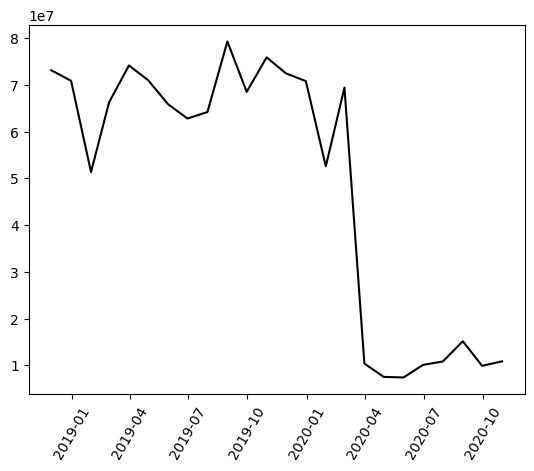

In [2]:
# 月ごとの売上を可視化する
import matplotlib.pyplot as plt
plt.plot(df_info['金額'].resample('M').sum(), color='k')
plt.xticks(rotation=60)
plt.show()

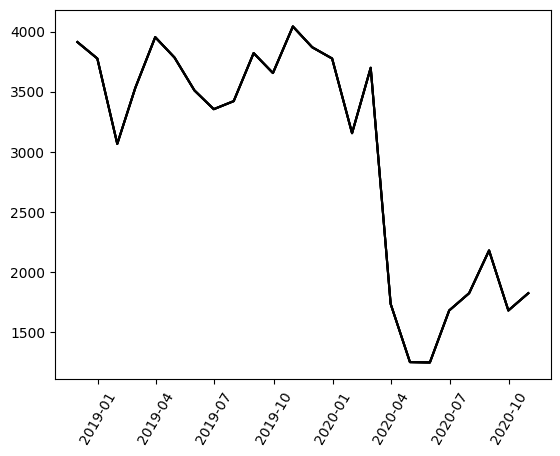

In [3]:
# 月ごとの利用者を可視化する
plt.plot(df_info.resample('M').count(), color='k')
plt.xticks(rotation=60)
plt.show()

売上も利用者も、感染症流行を経て激減している。

## 1-3. 平均値、中央値、最小値、最大値を出力してみよう
どのような利用者がいるのか全体像を把握するために、各利用者の統計値を確認する。

In [4]:
# 平均値、中央値、最小値、最大値の出力を行なう
x_mean = df_info['顧客ID'].value_counts().mean()
x_median = df_info['顧客ID'].value_counts().median()
x_min = df_info['顧客ID'].value_counts().min()
x_max = df_info['顧客ID'].value_counts().max()
print('平均値:', x_mean)
print('中央値:', x_median)
print('最小値:', x_min)
print('最大値:', x_max)

平均値: 13.073641997812613
中央値: 7.0
最小値: 1
最大値: 184


平均値が１３回なのに対して中央値が７回と大きく値がずれている。
利用者の利用回数が一様に分布していれば（利用回数が多い人も少ない人も、一様に存在すれば）平均値と中央値は概ね一致するので、利用回数の多少がまばらに分布しているなど、分布に偏りが見られると推測される。
実際に、最小値が１なのに対して最大値が 184, と最大値が平均値が遠い位置にあるため最小値に近い位置に利用回数が集中しており、最大値に近いところはまばらに点在しているのではないかと予想される。

## 1-4. 分布の形を見てみよう

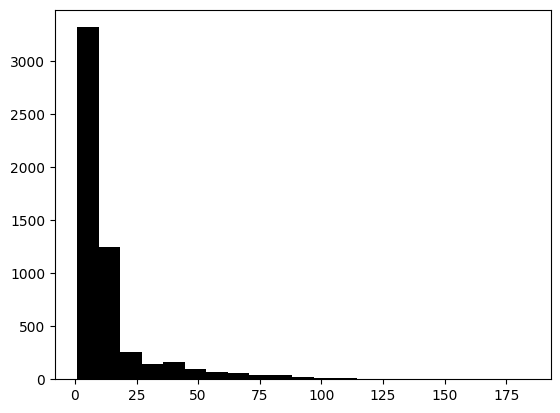

In [5]:
# 分布の可視化を行なう
x = df_info['顧客ID'].value_counts()
x_hist, t_hist,_ = plt.hist(x, 21, color='k')  # 第2引数は、最大値と最小値の間を分ける区間を設定
plt.show()

x軸: 利用頻度
y軸: 利用者数

ほどんどの利用者は１回のみ、あるいはごく少数の利用のみで少数だけ極めて多い回数の利用者が存在する。
※平均値が最小値側に大幅に偏っている理由

> #### べき分布
> ０付近に多くの Sample数が集中し、それ以降、急激に減少していく分布。

## 1-5. 分布の近似曲線を求めてみよう
分析している Data がどのような数式に基づく分布に従うのかを求め、Histogram 上に **「近似曲線」** を引き説得力を上げる。

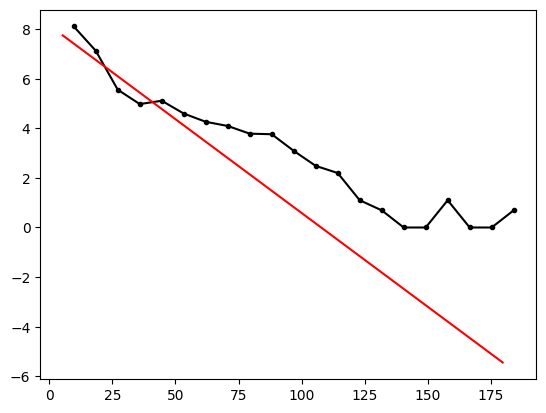

In [7]:
# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 15  # Fitting の区間を全体ではなく num で指定

# 変数設定
weight = x_hist[1:num]
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1, w=weight)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

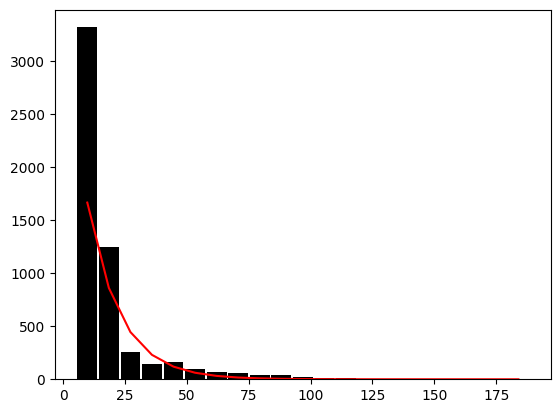

In [8]:
# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

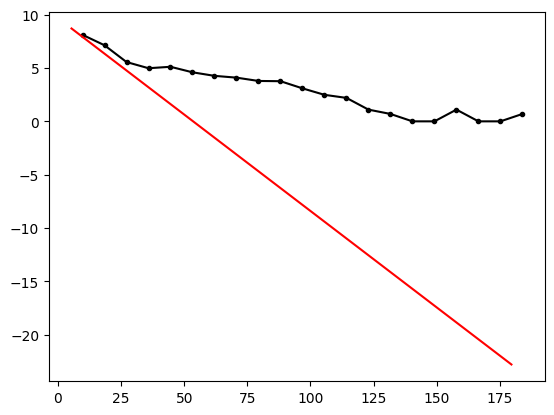

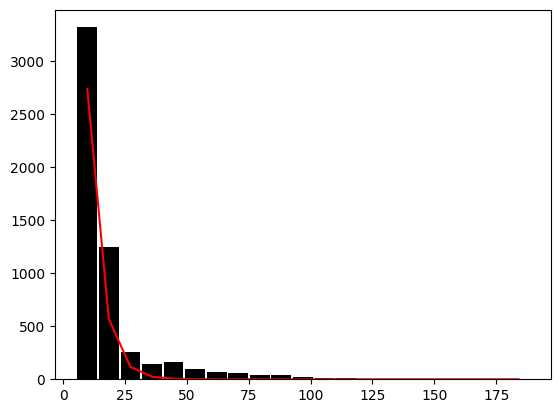

In [9]:
# 左側の Fitting を良く見せるため num を小さくする

# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 3  # Fitting の区間を全体ではなく num で指定

# 変数設定
weight = x_hist[1:num]
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1, w=weight)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

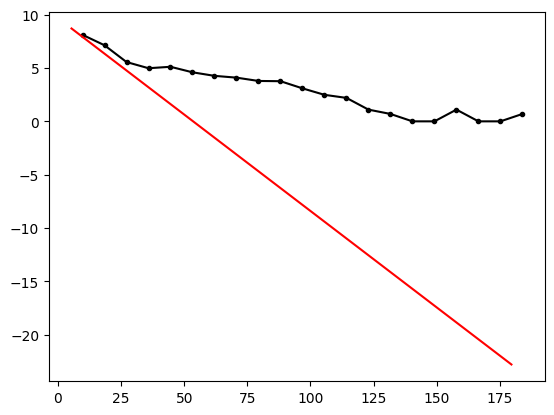

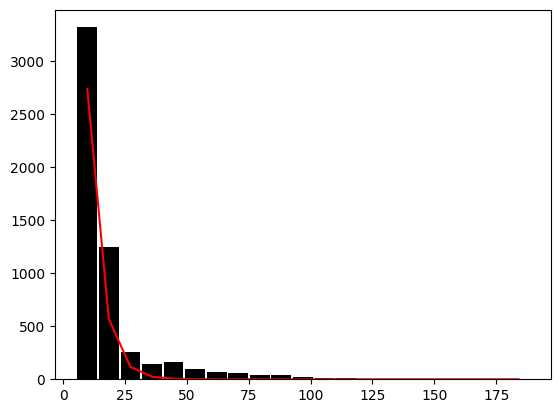

In [12]:
# 元の直線の Fitting に合わせる（全体の値に比較的忠実に従った Fitting）

# 近似曲線の Parameter を算出する
import numpy as np

# Parameter 設定
epsiron = 1  # x_hist の値が 0 だった場合、log をとると負の無限大に発散してしまうため、回避するために足しあわせる便宜上の値
num = 3  # Fitting の区間を全体ではなく num で指定

# 変数設定
t = np.zeros(len(t_hist) - 1)  # t_hist は、各区間の端点を表すため、区間の中心点を表す t に変換
for i in range(len(t_hist) - 1):
    t[i] = (t_hist[i] + t_hist[i + 1]) / 2

# Fitting（最小二乗近似）による Parameter の算出
a, b = np.polyfit(t[1:num], np.log(x_hist[1:num]), 1)
    # log p(x) = ax + b の Parameter の a, b を同時に求める
    # x には t を指定
    # y には x_hist の log をとったものである np.log(x_hist[1:num]) を指定
    # w  x_hist[1:num] を指定し縦軸の値が大きいほど近似曲線に Fitting する際の重みを強めるように指定

# Fitting曲線（直線）の描画
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = a * t[i] + b
plt.plot(t_hist[1:], np.log(x_hist + epsiron), marker='.', color='k')
plt.plot(t, xt, color='r')
plt.show()

# 近似曲線を描く
import math

t = t_hist[1:]
xt = np.zeros(len(t))
for i in range(len(t)):
    xt[i] = math.exp(a * t[i] + b)

plt.bar(t_hist[1:], x_hist, width=8, color='k')
plt.plot(t, xt, color='r')
plt.show()

近似曲線を描く場合は、
- なぜその曲線を描いたのか
- どのように描いたのか
- その曲線によってどのような意味を伝えたいのか

が重要。描いた近似曲線を自分自身が理解していないと、Data 対する誤った理解に繋がる。